In [1]:
#Pkg.update()
using PyPlot
using TestImages
using ImageFeatures
using Images
using TestImages
using ImageDraw


### About hog
- https://github.com/JuliaImages/ImageFeatures.jl/blob/master/docs/src/tutorials/object_detection.md

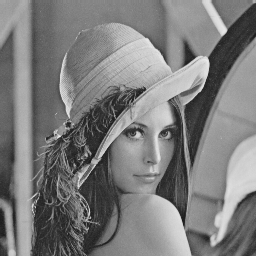

In [2]:
img = testimage("lena_gray")

In [3]:
typeof(img)

Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}

In [4]:
img_as_array = convert(Array{Float32},img);

In [5]:
minimum(img_as_array), maximum(img_as_array)

(0.10196079f0, 0.9490197f0)

## Descriptors

In [6]:
img = testimage("lena_gray")
gx = imfilter(img, centered([-1 0 1]))
gy = imfilter(img, centered([-1 0 1]'));

In [7]:
size(img), size(gx)

((256, 256), (256, 256))

In [8]:
img = testimage("lena_gray")
gx = imfilter(img, centered([-1 0 1]))
gy = imfilter(img, centered([-1 0 1]'));

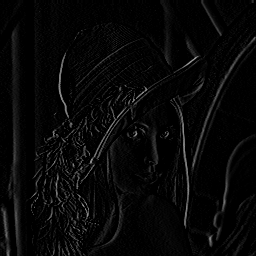

In [9]:
gx

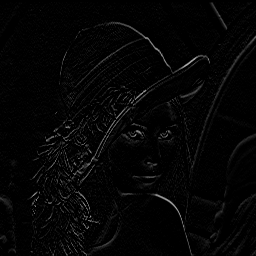

In [10]:
gy

### We can plot using PyPlot if we convert the images to standard arrays

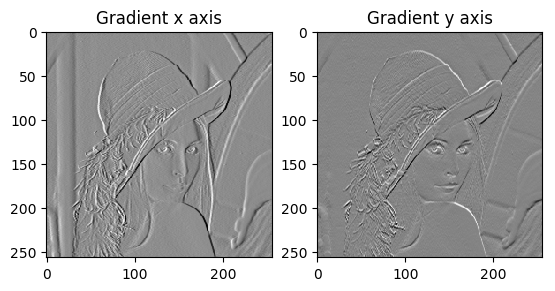

In [11]:
figure, axis = PyPlot.subplots(1,2);

axis[1][:imshow](convert(Array{Float32},gx), cmap="gray")
axis[1][:set_title]("Gradient x axis" )

axis[2][:imshow](convert(Array{Float32},gy), cmap="gray")
axis[2][:set_title]("Gradient y axis")

PyPlot.show()

## HOG descriptor

- https://github.com/JuliaImages/ImageFeatures.jl/blob/master/docs/src/tutorials/object_detection.md

In [12]:
?(HOG)

search: HOG hough_circle_gradient hough_transform_standard morphogradient



```
hog_params = HOG([orientations = 9], [cell_size = 8], [block_size = 2], [block_stride = 1], [norm_method = "L2-norm"])
```

Histogram of Oriented Gradient (HOG) is a dense feature desciptor usually used for object detection. See "Histograms of Oriented Gradients for Human Detection" by Dalal and Triggs.

Parameters:  

  * orientations   = number of orientation bins
  * cell_size      = size of a cell is cell_size x cell_size (in pixels)
  * block_size     = size of a block is block_size x block_size (in terms of cells)
  * block_stride   = stride of blocks. Controls how much adjacent blocks overlap.
  * norm_method    = block normalization method. Options: L2-norm, L2-hys, L1-norm, L2-sqrt.


In [13]:
typeof(img)

Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}

In [14]:
h = HOG(orientations=9,
        cell_size=8,
        block_size = 2,
        block_stride = 1,
        norm_method="L2-norm")

ImageFeatures.HOG(9, 8, 2, 1, "L2-norm")

In [15]:
@time hog_feautres = create_descriptor(img, HOG());

  1.012644 seconds (1.96 M allocations: 49.961 MiB, 2.54% gc time)


### Load pedestrian data

In [16]:
#path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"

path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)
pos_images = []
neg_images = []

for n in pos_example_names
    push!(pos_images, load( path_positive_examples * n))
end

for n in neg_example_names
    push!(neg_images, load( path_negative_examples * n))
end

In [17]:

path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"

#path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)

n_pos = length(pos_example_names)
n_neg = length(neg_example_names)

n = n_pos + n_neg                       # number of training examples 
data = Array{Float64}(3780, n)          # Array to store HOG descriptor of each image. Each image in our training data has size 128x64 and so has a 3780 length 
labels = Vector{Int64}(n);              # Vector to store label (1=human, 0=not human) of each image.

for (i, file) in enumerate([pos_example_names ; neg_example_names])
    
    #filename = "$(i <= n_pos ? path_positive_examples : path_negative_examples)/$file"
    if i <= n_pos
        filename =  path_positive_examples * file
    else
        filename = path_negative_examples * file
    end
    
    img = load(filename)   
    if i > n_pos # negative samples are bigger, we take a patch of the same shape
        img = img[1:128, 1:64]
    end
    
    data[:, i] = create_descriptor(img, HOG())
    labels[i] = (i <= n_pos ? 1 : 0)
end

In [18]:
println("size of the data:             ", size(data))
println("size of the labels:           ", size(labels))
println("number of negative labels:    ", sum(labels.==0))
println("number of positive labels:    ", sum(labels.==1))

size of the data:             (3780, 974)
size of the labels:           (974,)
number of negative labels:    50
number of positive labels:    924


In [19]:
using LIBSVM

# Split the dataset into train and test set. Train set = 2500 images, Test set = 294 images.
random_perm = randperm(n)
train_ind = random_perm[1:700]
test_ind = random_perm[700:end]
#train_ind = 1:n

model = svmtrain(data[:, train_ind], labels[train_ind]);

In [20]:
# be careful about the size of the data!
# THIS WILL NOT WORK
# svmpredict(model, data[:,5])

In [21]:
descriptor =  data[:,2];
print(size(descriptor))

descriptor =  data[:,2:2];
print(size(descriptor))

(3780,)(3780, 1)

In [22]:
m = 100
print("True label:", labels[m])
descriptor =  data[:,m:m];
predicted_label, s = svmpredict(model, descriptor)

True label:1

([1], [1.00736; 0.0])

In [23]:
m = 966
print("True label:", labels[m])
descriptor =  data[:,m:m];
predicted_label, s = svmpredict(model, descriptor)

True label:0

([1], [0.909075; 0.0])

### Model evaluation train set

In [24]:
predicted_labels, _ = svmpredict(model,data);

In [25]:
sum(predicted_labels .== labels) / length(labels)

0.9486652977412731

In [26]:
# this classier allways predicts no pedestrian (not very usefull..)
sum(predicted_labels .== 0)

0

### Testing the learned model

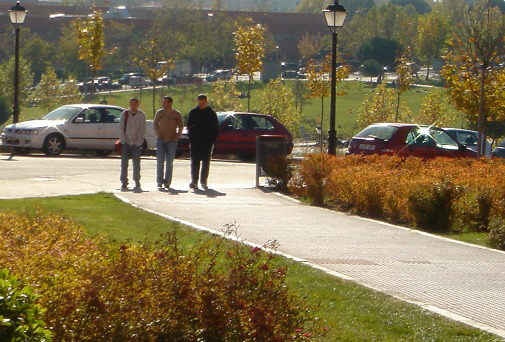

In [27]:
img = load("tutorial/humans.jpg")

In [70]:
rows, cols = size(img)

scores = Array{Float64}(22, 45)
descriptor = Array{Float64}(3780, 1)

#Apply classifier using a sliding window approach and store classification score for not-human at every location in score array
for j in 32:10:cols-32
    for i in 64:10:rows-64
        #box = img[i-63:i+64, j-31:j+32]
        box = view(img,i-63:i+64, j-31:j+32)
        descriptor[:, 1]   = create_descriptor(box, HOG())
        print(typeof(descriptor)); print(size(descriptor)); break
        predicted_label, s = svmpredict(model, descriptor);
        scores[Int((i-64)/10)+1, Int((j-32)/10)+1] = s[1]
    end
end

Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)Array{Float64,2}(3780, 1)

You can see that classifier gave low score to not-human class (i.e. high score to human class) at positions corresponding to humans in the original image. Below we threshold the image and supress non-minimal values to get the human locations. We then plot the bounding boxes using ImageDraw.



In [63]:
#i = 35; j=30
#box = img[i-63:i+64, j-31:j+32]
#create_descriptor(box, HOG())

In [64]:
svmpredict(model,descriptor)

([1], [0.96735; 0.0])

In [65]:
scores[scores.>0] = 0
object_locations = findlocalminima(scores)

8-element Array{CartesianIndex{2},1}:
 CartesianIndex{2}((12, 11))
 CartesianIndex{2}((7, 12)) 
 CartesianIndex{2}((2, 18)) 
 CartesianIndex{2}((19, 18))
 CartesianIndex{2}((8, 23)) 
 CartesianIndex{2}((3, 24)) 
 CartesianIndex{2}((16, 35))
 CartesianIndex{2}((22, 37))

In [66]:
rectangles = [[((i[2]-1)*10+1, (i[1]-1)*10+1), ((i[2]-1)*10+64, (i[1]-1)*10+1), 
              ((i[2]-1)*10+64, (i[1]-1)*10+128), ((i[2]-1)*10+1, (i[1]-1)*10+128)]
               for i in object_locations];

In [67]:
rectangles

8-element Array{Array{Tuple{Int64,Int64},1},1}:
 Tuple{Int64,Int64}[(101, 111), (164, 111), (164, 238), (101, 238)]
 Tuple{Int64,Int64}[(111, 61), (174, 61), (174, 188), (111, 188)]  
 Tuple{Int64,Int64}[(171, 11), (234, 11), (234, 138), (171, 138)]  
 Tuple{Int64,Int64}[(171, 181), (234, 181), (234, 308), (171, 308)]
 Tuple{Int64,Int64}[(221, 71), (284, 71), (284, 198), (221, 198)]  
 Tuple{Int64,Int64}[(231, 21), (294, 21), (294, 148), (231, 148)]  
 Tuple{Int64,Int64}[(341, 151), (404, 151), (404, 278), (341, 278)]
 Tuple{Int64,Int64}[(361, 211), (424, 211), (424, 338), (361, 338)]

In [68]:
using ImageDraw

In [69]:
for rec in rectangles
    draw!(img, Polygon(rec), RGB{N0f8}(0, 0, 1.0))
end
imshow(img)

LoadError: [91mPyError (ccall(@pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, arg, C_NULL)) <type 'exceptions.TypeError'>
TypeError(u'Image data can not convert to float',)
  File "/home/david/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py", line 3157, in imshow
    **kwargs)
  File "/home/david/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py", line 1898, in inner
    return func(ax, *args, **kwargs)
  File "/home/david/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py", line 5124, in imshow
    im.set_data(X)
  File "/home/david/anaconda/lib/python2.7/site-packages/matplotlib/image.py", line 596, in set_data
    raise TypeError("Image data can not convert to float")
[39m